In [17]:
!pip install langchain langchain-core langchain_community langgraph langchain-huggingface transformers torch

In [2]:
#!pip install unstructured

from langchain_community.document_loaders import UnstructuredURLLoader

urls = ['https://langchain-ai.github.io/langgraph/tutorials/introduction/']
loader = UnstructuredURLLoader(urls=urls)
docs = loader.load()


In [18]:
#docs

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

print("Total number of documents: ",len(all_splits))

Total number of documents:  98


In [5]:
all_splits[7]

Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/'}, page_content="Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabilities. It's particularly useful for developing more complex, stateful AI applications that go beyond simple query-response interactions.\nGoodbye!\n\nCongratulations! You've built your first chatbot using LangGraph. This bot can engage in basic conversation by taking user input and generating responses using an LLM. You can inspect a LangSmith Trace for the call above at the provided link.\n\nHowever, you may have noticed that the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search too

In [6]:

# Embedding models: https://python.langchain.com/v0.1/docs/integrations/text_embedding/

# Let's load the Hugging Face Embedding class.  sentence_transformers
from langchain_community.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings()

vector = embeddings.embed_query("hello, world!")
vector[:5]

<ipython-input-6-4c91a361ae8b>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings()
<ipython-input-6-4c91a361ae8b>:5: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingf

[0.03492268547415733,
 0.0188300758600235,
 -0.017854738980531693,
 0.0001388332893839106,
 0.07407363504171371]

In [8]:
#!pip install langchain_chroma

from langchain_chroma import Chroma
from langchain_core.documents import Document

vectorstore = Chroma.from_documents(documents=all_splits, embedding=HuggingFaceEmbeddings())

# if you want to store chromadb locally

# vectorstore = Chroma.from_documents(
#     documents=docs,
#     embedding=HuggingFaceEmbeddings(),
#     persist_directory="./my_chroma_db"  # Custom directory
# )


# Loading the Database Later
# This reloads the previously stored embeddings so you don’t have to recompute them.

# vectorstore = Chroma(
#     persist_directory="./my_chroma_db",
#     embedding_function=HuggingFaceEmbeddings()
# )

<ipython-input-8-43e6a2a5b884>:6: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  vectorstore = Chroma.from_documents(documents=all_splits, embedding=HuggingFaceEmbeddings())


In [9]:
from langchain_huggingface import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import pipeline
from langchain_core.output_parsers import StrOutputParser
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer


#model_id = "meta-llama/Meta-Llama-3-8B"
model_id = "tiiuae/falcon-7b"

# text_generation_pipeline = pipeline(
#     "text-generation", model=model_id, model_kwargs={"torch_dtype": torch.bfloat16}, max_new_tokens=400, device=0)


text_generation_pipeline = pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    max_new_tokens=200,
    device=0,
    temperature=0.7,  #  (lower values = more deterministic)
    top_k=50,  # Filters out low-probability tokens
)


llm = HuggingFacePipeline(pipeline=text_generation_pipeline)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [10]:
# from langchain_core.prompts import PromptTemplate

# template = """Use the following pieces of context to answer the question at the end.
# If you don't know the answer, just say that you don't know, don't try to make up an answer.
# Use three sentences maximum and keep the answer as concise as possible.
# Always say "thanks for asking!" at the end of the answer.

# {context}

# Question: {question}

# Helpful Answer:"""
# prompt = PromptTemplate.from_template(template)


from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [11]:
from typing_extensions import List, TypedDict

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


In [12]:
# Define application steps
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"],  k=1)
    return {"context": retrieved_docs}



In [13]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    #return {"answer": response.content}
    return {"answer": response}



In [14]:
from langgraph.graph import START, StateGraph

# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

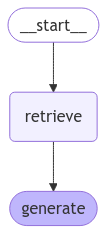

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
response = graph.invoke({"question": "what is langgraph?"})
print(response["answer"])

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: what is langgraph? 
Context: Thank you for your patience. I've found some recent information about LangGraph for you. Let me summarize the key points:

1. LangGraph is part of the LangChain ecosystem, which is a leading platform in AI development.

2. Recent updates and features of LangGraph include:

   a. LangGraph Cloud: This seems to be a cloud-based version of LangGraph, though specific details weren't provided in the search results.

   b. LangGraph Platform: This is a newly introduced concept that combines several offerings:
      - LangGraph Server
      - LangGraph Studio
      - CLI (Command Line Interface)
      - SDK (Software Development Kit)

3. LangGraph Server: This component has received new features to enhance its val